In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt # draw graph

#import os
#path=
#print(os.listdir("../My Drive"))

from google.colab import drive
drive.mount('/gdrive')
%cd /gdrive/


Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /gdrive
/gdrive


In [2]:
train = pd.read_csv("/gdrive/My Drive/train.csv")
test = pd.read_csv("/gdrive/My Drive/test_id.csv")

print(train.shape, test.shape)

(35544, 5) (2226, 4)


In [0]:
#from google.colab import drive
#drive.mount('/gdrive')

Drive already mounted at /gdrive; to attempt to forcibly remount, call drive.mount("/gdrive", force_remount=True).


In [3]:
train['count_date'] = pd.to_datetime(train['UPDATE_TIME']) - pd.to_datetime('2017-10-01')
train['count_date'] = train['count_date'].astype(int) // 86400000000000
train['week'] = train['count_date'] // 7
train['day_of_week'] = pd.to_datetime(train['UPDATE_TIME']).dt.dayofweek
train.head()

,UPDATE_TIME,ZONE_CODE,HOUR_ID,BANDWIDTH_TOTAL,MAX_USER,count_date,week,day_of_week
0,2017-10-01,ZONE01,0,16096.710313,212415.0,0,0,6
1,2017-10-01,ZONE01,1,9374.207907,166362.0,0,0,6
2,2017-10-01,ZONE01,2,5606.225750,146370.0,0,0,6
3,2017-10-01,ZONE01,3,4155.654661,141270.0,0,0,6
4,2017-10-01,ZONE01,4,3253.978594,139689.0,0,0,6


In [4]:
test['count_date'] = pd.to_datetime(test['UPDATE_TIME']) - pd.to_datetime('2017-10-01')
test['count_date'] = test['count_date'].astype(int) // 86400000000000
test['week'] = test['count_date'] // 7
test['day_of_week'] = pd.to_datetime(test['UPDATE_TIME']).dt.dayofweek
test.head()

,id,UPDATE_TIME,ZONE_CODE,HOUR_ID,count_date,week,day_of_week
0,0,2019-03-10,ZONE01,0,525,75,6
1,1,2019-03-10,ZONE01,1,525,75,6
2,2,2019-03-10,ZONE01,2,525,75,6
3,3,2019-03-10,ZONE01,3,525,75,6
4,4,2019-03-10,ZONE01,4,525,75,6


FUNCTION

SMAPE

SMAPE = 100/n * |Ft - At|/(|Ft| + |At|)

At: actual value

Ft: predict value

Res = 0.8 x SMAPE of BANDWIDTH_TOTAL + 0.2 x SMAPE of MAX_USER

In [0]:
def SMAPE(n, predict, actual):
    return sum(np.abs(predict - actual) / (np.abs(predict) + np.abs(actual)) * 100 / n)

# _train  : training set
# feature : name feature
# y       : label
def linearForFeature(_train, feature ,y):
    len_train = len(_train)
    one = np.ones((len_train,1), dtype=float)
    
    feature1 = np.array(_train[feature]).reshape(len_train,1)
    label = np.array(_train[y]).reshape(len_train,1)
    features = np.concatenate((one, feature1, feature1 * feature1), axis=1)
    
    # nomal-equaltion
    A,b = features.T @ features, features.T @ label
    theta = np.linalg.pinv(A) @ b
    return theta

Count zone

In [6]:
zone_labels = sorted(set(train["ZONE_CODE"].values))
print('ZONE_CODE:', zone_labels)

# for zone in zone_labels:
#     train[train.ZONE_CODE == zone].groupby(['UPDATE_TIME']).mean()['BANDWIDTH_TOTAL'].plot()

ZONE_CODE: ['ZONE01', 'ZONE02', 'ZONE03']


BANDWIDTH

ZONE01

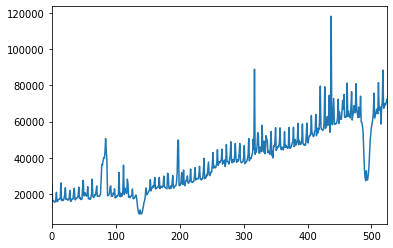

In [7]:
zone1 = train[train.ZONE_CODE == 'ZONE01'].copy().reset_index()
zone1_gpby_mean = zone1.groupby('UPDATE_TIME').mean().reset_index()

zone1_gpby_mean['BANDWIDTH_TOTAL'].plot()

Drop lunar new year :v

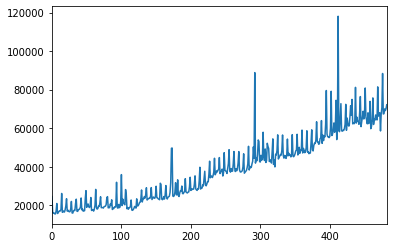

In [8]:
# Drop 
zone1_bandwidth = zone1_gpby_mean.drop(zone1_gpby_mean.index[485:502])
zone1_bandwidth = zone1_bandwidth.drop(zone1_bandwidth.index[133:146])
zone1_bandwidth = zone1_bandwidth.drop(zone1_bandwidth.index[76:88]).reset_index()

zone1_bandwidth['BANDWIDTH_TOTAL'].plot()

In [9]:
zone1_theta_bandwidth = linearForFeature(zone1_bandwidth,'count_date','BANDWIDTH_TOTAL')
print(zone1_theta_bandwidth)

zone1_rate_bandwidth = zone1.groupby(['day_of_week','HOUR_ID']).mean().BANDWIDTH_TOTAL / zone1.mean().BANDWIDTH_TOTAL
# zone1 = pd.merge(zone1, pd.DataFrame({'rate_hour_id_bandwidth' : zone1_rate_bandwidth}), on=['day_of_week','HOUR_ID']).sort_values('index').reset_index().drop(columns='level_0')
for i in range(168):
    zone1.loc[zone1.day_of_week*24 + zone1.HOUR_ID == i,'rate_hour_id_bandwidth'] = zone1_rate_bandwidth[i//24][i%24]

[[1.61308135e+04]
 [3.56787736e+01]
 [1.46720244e-01]]


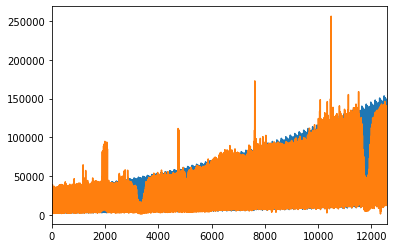

In [10]:
zero = np.zeros((len(zone1),1)) 
one = np.ones((len(zone1),1))
count_date = zone1['count_date'][:, np.newaxis]

zone1['predict_bandwidth'] = np.concatenate((one, count_date, count_date*count_date), axis=1) @ zone1_theta_bandwidth
zone1['predict_bandwidth'] = zone1['predict_bandwidth'] * zone1['rate_hour_id_bandwidth']

# print(SMAPE(len(zone1), zone1.predict_bandwidth, zone1.BANDWIDTH_TOTAL))
# zone1
# plt.figure(figsize=(12,5), dpi=160)
zone1.predict_bandwidth.plot()
zone1.BANDWIDTH_TOTAL.plot()

ZONE02

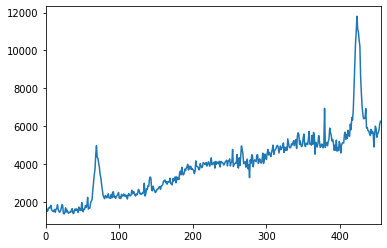

In [0]:
zone2 = train[train.ZONE_CODE == 'ZONE02'].copy().reset_index()
zone2_gpby_mean = zone2.groupby('UPDATE_TIME').mean().reset_index()

zone2_gpby_mean['BANDWIDTH_TOTAL'].plot()

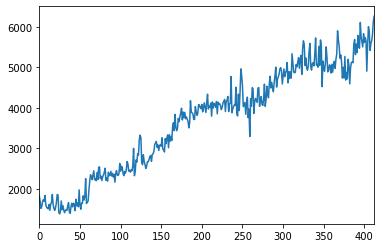

In [0]:
# Drop 
zone2_bandwidth = zone2_gpby_mean.drop(zone2_gpby_mean.index[415:439])
zone2_bandwidth = zone2_bandwidth.drop(zone2_bandwidth.index[379])
zone2_bandwidth = zone2_bandwidth.drop(zone2_bandwidth.index[62:80]).reset_index()
zone2_bandwidth['BANDWIDTH_TOTAL'].plot()

In [0]:
zone2_theta_bandwidth = linearForFeature(zone2_bandwidth,'count_date','BANDWIDTH_TOTAL')
print(zone2_theta_bandwidth)

zone2_rate_bandwidth = zone2.groupby(['day_of_week','HOUR_ID']).mean().BANDWIDTH_TOTAL / zone2.mean().BANDWIDTH_TOTAL
for i in range(168):
    zone2.loc[zone2.day_of_week*24 + zone2.HOUR_ID == i,'rate_hour_id_bandwidth'] = zone2_rate_bandwidth[i//24][i%24]

[[ 2.46400945e+02]
 [ 1.40323958e+01]
 [-6.53031705e-03]]


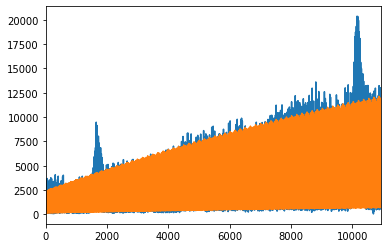

In [0]:
zero = np.zeros((len(zone2),1)) 
one = np.ones((len(zone2),1))
count_date = zone2['count_date'][:, np.newaxis]

zone2['predict_bandwidth'] = np.concatenate((one, count_date, count_date*count_date), axis=1) @ zone2_theta_bandwidth
zone2['predict_bandwidth'] = zone2['predict_bandwidth'] * zone2['rate_hour_id_bandwidth']

# zone2
# plt.figure(figsize=(12,5), dpi=160)
zone2.BANDWIDTH_TOTAL.plot()
zone2.predict_bandwidth.plot()

ZONE03

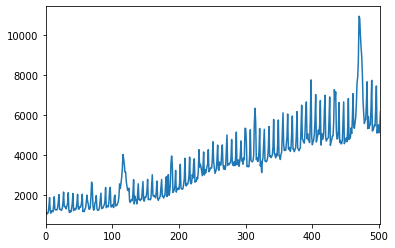

In [0]:
zone3 = train[train.ZONE_CODE == 'ZONE03'].copy().reset_index()
zone3_gpby_mean = zone3.groupby('UPDATE_TIME').mean().reset_index()

zone3_gpby_mean['BANDWIDTH_TOTAL'].plot()

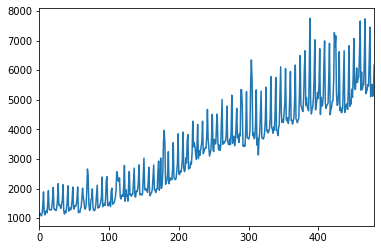

In [0]:
# Drop 
zone3_bandwidth = zone3_gpby_mean.drop(zone3_gpby_mean.index[465:477])
zone3_bandwidth = zone3_bandwidth.drop(zone3_bandwidth.index[112:122]).reset_index()
zone3_bandwidth['BANDWIDTH_TOTAL'].plot()

In [0]:
zone3_theta_bandwidth = linearForFeature(zone3_bandwidth,'count_date','BANDWIDTH_TOTAL')
print(zone3_theta_bandwidth)

zone3_rate_bandwidth = zone3.groupby(['day_of_week','HOUR_ID']).mean().BANDWIDTH_TOTAL / zone3.mean().BANDWIDTH_TOTAL
for i in range(168):
    zone3.loc[zone3.day_of_week*24 + zone3.HOUR_ID == i,'rate_hour_id_bandwidth'] = zone3_rate_bandwidth[i//24][i%24]

[[8.19292590e+02]
 [8.13488661e+00]
 [4.07882403e-03]]


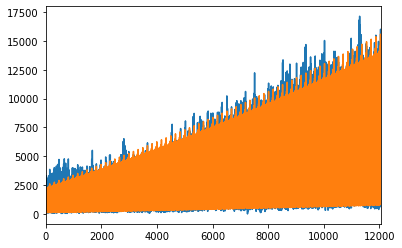

In [0]:
zero = np.zeros((len(zone3),1)) 
one = np.ones((len(zone3),1))
count_date = zone3['count_date'][:, np.newaxis]

zone3['predict_bandwidth'] = np.concatenate((one, count_date, count_date*count_date), axis=1) @ zone3_theta_bandwidth
zone3['predict_bandwidth'] = zone3['predict_bandwidth'] * zone3['rate_hour_id_bandwidth']

# zone3
# plt.figure(figsize=(12,5), dpi=160)
zone3.BANDWIDTH_TOTAL.plot()
zone3.predict_bandwidth.plot()

MAXUSER

ZONE01

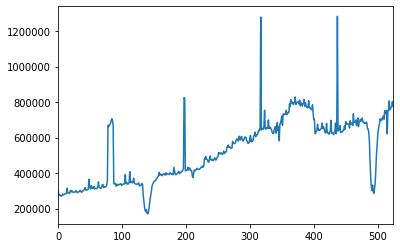

In [0]:
zone1_gpby_mean.MAX_USER.plot()

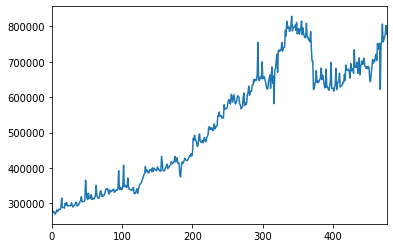

In [0]:
# Drop
zone1_maxuser = zone1_gpby_mean.drop(zone1_gpby_mean.index[485:501])
zone1_maxuser = zone1_maxuser.drop(zone1_maxuser.index[436:438])
zone1_maxuser = zone1_maxuser.drop(zone1_maxuser.index[316:318])
zone1_maxuser = zone1_maxuser.drop(zone1_maxuser.index[196:199])
zone1_maxuser = zone1_maxuser.drop(zone1_maxuser.index[132:147])
zone1_maxuser = zone1_maxuser.drop(zone1_maxuser.index[77:87]).reset_index()
zone1_maxuser['MAX_USER'].plot()

In [0]:
zone1_theta_maxuser = linearForFeature(zone1_maxuser,'count_date','MAX_USER')
print(zone1_theta_maxuser)

zone1_rate_maxuser = zone1.groupby(['day_of_week','HOUR_ID']).mean().MAX_USER / zone1.mean().MAX_USER
for i in range(168):
    zone1.loc[zone1.day_of_week*24 + zone1.HOUR_ID == i,'rate_hour_id_maxuser'] = zone1_rate_maxuser[i//24][i%24]

[[ 2.24803236e+05]
 [ 1.36703952e+03]
 [-6.35817168e-01]]


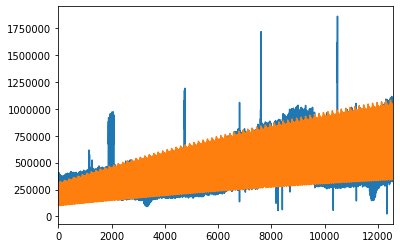

In [0]:
zero = np.zeros((len(zone1),1)) 
one = np.ones((len(zone1),1))
count_date = zone1['count_date'][:, np.newaxis]

zone1['predict_maxuser'] = np.concatenate((one, count_date, count_date*count_date), axis=1) @ zone1_theta_maxuser  
zone1['predict_maxuser'] = (zone1['predict_maxuser'] * zone1['rate_hour_id_maxuser']).astype(int)

# zone1
# plt.figure(figsize=(12,5), dpi=160)
zone1.MAX_USER.plot()
zone1.predict_maxuser.plot()

ZONE02

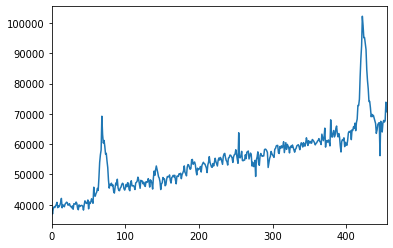

In [0]:
zone2_gpby_mean.MAX_USER.plot()

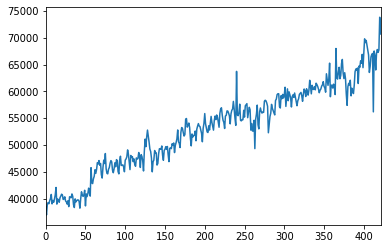

In [0]:
# Drop
zone2_maxuser = zone2_gpby_mean.drop(zone2_gpby_mean.index[415:435])
zone2_maxuser = zone2_maxuser.drop(zone2_maxuser.index[64:78]).reset_index()
zone2_maxuser['MAX_USER'].plot()

In [0]:
zone2_theta_maxuser = linearForFeature(zone2_maxuser,'count_date','MAX_USER')
print(zone2_theta_maxuser)

zone2_rate_maxuser = zone2.groupby(['day_of_week','HOUR_ID']).mean().MAX_USER / zone2.mean().MAX_USER
for i in range(168):
    zone2.loc[zone2.day_of_week*24 + zone2.HOUR_ID == i,'rate_hour_id_maxuser'] = zone2_rate_maxuser[i//24][i%24]

[[ 3.36917950e+04]
 [ 7.40968649e+01]
 [-2.26779453e-02]]


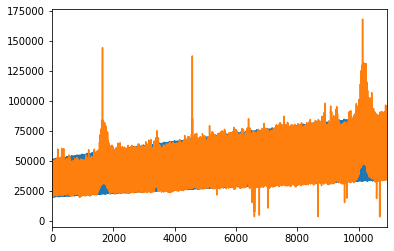

In [0]:
zero = np.zeros((len(zone2),1)) 
one = np.ones((len(zone2),1))
count_date = zone2['count_date'][:, np.newaxis]

zone2['predict_maxuser'] = np.concatenate((one, count_date, count_date*count_date), axis=1) @ zone2_theta_maxuser  
zone2['predict_maxuser'] = (zone2['predict_maxuser'] * zone2['rate_hour_id_maxuser']).astype(int)

# zone2
# plt.figure(figsize=(12,5), dpi=160)

zone2.predict_maxuser.plot()
zone2.MAX_USER.plot()

ZONE03

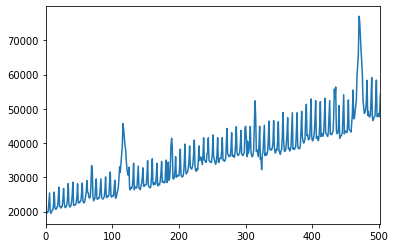

In [0]:
zone3_gpby_mean.MAX_USER.plot()

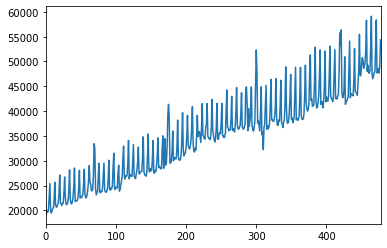

In [0]:
# # Drop
zone3_maxuser = zone3_gpby_mean.drop(zone3_gpby_mean.index[466:477])
zone3_maxuser = zone3_maxuser.drop(zone3_maxuser.index[110:124]).reset_index()
zone3_maxuser['MAX_USER'].plot()

In [0]:
zone3_theta_maxuser = linearForFeature(zone3_maxuser,'count_date','MAX_USER')
print(zone3_theta_maxuser)

zone3_rate_maxuser = zone3.groupby(['day_of_week','HOUR_ID']).mean().MAX_USER / zone3.mean().MAX_USER
for i in range(168):
    zone3.loc[zone3.day_of_week*24 + zone3.HOUR_ID == i,'rate_hour_id_maxuser'] = zone3_rate_maxuser[i//24][i%24]

[[1.97383995e+04]
 [5.65237163e+01]
 [1.36363743e-03]]


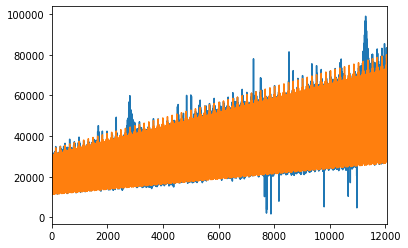

In [0]:
zero = np.zeros((len(zone3),1)) 
one = np.ones((len(zone3),1))
count_date = zone3['count_date'][:, np.newaxis]

zone3['predict_maxuser'] = np.concatenate((one, count_date, count_date*count_date), axis=1) @ zone3_theta_maxuser  
zone3['predict_maxuser'] = (zone3['predict_maxuser'] * zone3['rate_hour_id_maxuser']).astype(int)

# zone3
# plt.figure(figsize=(12,5), dpi=160)
zone3.MAX_USER.plot()
zone3.predict_maxuser.plot()

Predict

In [0]:
for i in range(test.shape[0]):
    # ZONE01
    if test.loc[i,'ZONE_CODE'] == 'ZONE01':
        # BANDWIDTH
        test.loc[i,'rate_hour_id_bandwidth'] = zone1_rate_bandwidth[test.loc[i,'day_of_week']][test.loc[i,'HOUR_ID']]
        test.loc[i,'predict_bandwidth'] = zone1_theta_bandwidth[0] + zone1_theta_bandwidth[1]*test.loc[i,'count_date'] + zone1_theta_bandwidth[2]*test.loc[i,'count_date']*test.loc[i,'count_date']
        # MAX_USER
        test.loc[i,'rate_hour_id_maxuser'] = zone1_rate_maxuser[test.loc[i,'day_of_week']][test.loc[i,'HOUR_ID']]
        test.loc[i,'predict_maxuser'] = zone1_theta_maxuser[0] + zone1_theta_maxuser[1]*test.loc[i,'count_date'] + zone1_theta_maxuser[2]*test.loc[i,'count_date']*test.loc[i,'count_date']
    # ZONE02
    elif test.loc[i,'ZONE_CODE'] == 'ZONE02':
        # BANDWIDTH
        test.loc[i,'rate_hour_id_bandwidth'] = zone2_rate_bandwidth[test.loc[i,'day_of_week']][test.loc[i,'HOUR_ID']]
        test.loc[i,'predict_bandwidth'] = zone2_theta_bandwidth[0] + zone2_theta_bandwidth[1]*test.loc[i,'count_date'] + zone2_theta_bandwidth[2]*test.loc[i,'count_date']*test.loc[i,'count_date']
        # MAX_USER
        test.loc[i,'rate_hour_id_maxuser'] = zone2_rate_maxuser[test.loc[i,'day_of_week']][test.loc[i,'HOUR_ID']]
        test.loc[i,'predict_maxuser'] = zone2_theta_maxuser[0] + zone2_theta_maxuser[1]*test.loc[i,'count_date'] + zone2_theta_maxuser[2]*test.loc[i,'count_date']*test.loc[i,'count_date']
    # ZONE03
    else:
        # BANDWIDTH
        test.loc[i,'rate_hour_id_bandwidth'] = zone3_rate_bandwidth[test.loc[i,'day_of_week']][test.loc[i,'HOUR_ID']]
        test.loc[i,'predict_bandwidth'] = zone3_theta_bandwidth[0] + zone3_theta_bandwidth[1]*test.loc[i,'count_date'] + zone3_theta_bandwidth[2]*test.loc[i,'count_date']*test.loc[i,'count_date']
        # MAX_USER
        test.loc[i,'rate_hour_id_maxuser'] = zone3_rate_maxuser[test.loc[i,'day_of_week']][test.loc[i,'HOUR_ID']]
        test.loc[i,'predict_maxuser'] = zone3_theta_maxuser[0] + zone3_theta_maxuser[1]*test.loc[i,'count_date'] + zone3_theta_maxuser[2]*test.loc[i,'count_date']*test.loc[i,'count_date']
    
test['predict_bandwidth'] = (test['predict_bandwidth'] * test['rate_hour_id_bandwidth']).round(2)
test['predict_maxuser'] = (test['predict_maxuser'] * test['rate_hour_id_maxuser']).astype(int)
test.head()

,id,UPDATE_TIME,ZONE_CODE,HOUR_ID,count_date,week,day_of_week,rate_hour_id_bandwidth,predict_bandwidth,rate_hour_id_maxuser,predict_maxuser
0,0,2019-03-10,ZONE01,0,525,75,6,0.885355,66668.96,0.840683,645015
1,1,2019-03-10,ZONE01,1,525,75,6,0.507149,38189.31,0.635614,487676
2,2,2019-03-10,ZONE01,2,525,75,6,0.328881,24765.35,0.538276,412993
3,3,2019-03-10,ZONE01,3,525,75,6,0.236844,17834.83,0.482006,369820
4,4,2019-03-10,ZONE01,4,525,75,6,0.198260,14929.36,0.473299,363139


In [0]:
test['label'] = test['predict_bandwidth'].astype(str) + " " + test['predict_maxuser'].astype(str)
test[['id','label']].to_csv('/gdrive/My Drive/sub_aivn_server2.csv', index=False)
test[['id','label']].head()

,id,label
0,0,66668.96 645015
1,1,38189.31 487676
2,2,24765.35 412993
3,3,17834.83 369820
4,4,14929.36 363139
